In [24]:
import pandas as pd
import numpy as np
data_rfe=pd.read_csv('norm_baiyunshan.csv')
data_rfe=np.array(data_rfe)
fea=data_rfe[:,:49]
target=data_rfe[:,49]
x_test=fea[:170,:]
y_test=target[:170]
x_train=fea[170:,:]
y_train=target[170:]

# SVM-RFE_RELIEF

In [25]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_relief_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,alpha,folds):
        #kf=KFold(n_splits=folds,shuffle=False)
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,x_train,y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,x_train,y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            #print(relief_score)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
    def sele_feature(self,alpha,optim_featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        i=featu_num
        while True:
            if len(candi_fea)==optim_featur_num:
                return candi_fea
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(i)
            i-=1

In [26]:
rfe_relief_model=rfe_relief_SVM(x_train,y_train,1.5,0.1)

In [27]:
aver_mean_lis1,F_measure_lis1=rfe_relief_model.featu_score(0.15,5)
print(aver_mean_lis1,F_measure_lis1)

[0.7896680411294953, 0.788648937836004, 0.7881361240148234, 0.7932512135288897, 0.8004045096299389, 0.8009134088417976, 0.8004058144997129, 0.7978482697426796, 0.7764157837047863, 0.7774374967378256, 0.7764170885745603, 0.7748825617203403, 0.7748864763296622, 0.7748851714598882, 0.773864763296623, 0.7743762722480296, 0.7764183934443343, 0.7810102301790282, 0.7804974163578475, 0.7794796179341301, 0.7789681089827235, 0.7656910590323086, 0.7662077874628113, 0.7631413434939194, 0.7616120361187954, 0.7621339840283939, 0.753453990291769, 0.7549924317553108, 0.7570293334725193, 0.7554987212276215, 0.7580536562451067, 0.757540842423926, 0.7570306383422934, 0.7529463959496844, 0.7534552951615427, 0.7524348869982778, 0.7468200323607704, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7330432172869148, 0.7294717887154862, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0.

In [28]:
aver_mean_lis2,F_measure_lis2=rfe_relief_model.featu_score(0.25,5)
print(aver_mean_lis2,F_measure_lis2)

[0.7896680411294953, 0.788648937836004, 0.7881361240148234, 0.7932512135288897, 0.8004045096299389, 0.8009134088417976, 0.8004058144997129, 0.7978482697426796, 0.7764170885745603, 0.7759055796231537, 0.7764144788350122, 0.7748838665901143, 0.7764183934443343, 0.7759068844929276, 0.7733558640847644, 0.7753992901508429, 0.7769299023957409, 0.7815204342606608, 0.7804961114880735, 0.7794796179341301, 0.7774374967378256, 0.766714076935122, 0.7677410094472572, 0.763650242705778, 0.7626337491518347, 0.7621339840283939, 0.753453990291769, 0.7549924317553108, 0.7570293334725193, 0.7554987212276215, 0.7580536562451067, 0.757540842423926, 0.7570306383422934, 0.7529463959496844, 0.7534552951615427, 0.7524348869982778, 0.7468200323607704, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7330432172869148, 0.7294717887154862, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0.7

In [29]:
aver_mean_lis3,F_measure_lis3=rfe_relief_model.featu_score(0.35,5)
print(aver_mean_lis3,F_measure_lis3)

[0.7896680411294953, 0.788648937836004, 0.7881361240148234, 0.7932512135288897, 0.8004045096299389, 0.8009134088417976, 0.8004058144997129, 0.7978482697426796, 0.7764170885745603, 0.7759055796231537, 0.7764144788350122, 0.7748838665901143, 0.7764183934443343, 0.7759068844929276, 0.7733558640847644, 0.7753992901508429, 0.7769299023957409, 0.7815204342606608, 0.7804961114880735, 0.7794796179341301, 0.7774374967378256, 0.766714076935122, 0.7677410094472572, 0.763650242705778, 0.7626337491518347, 0.7621339840283939, 0.753453990291769, 0.7549924317553108, 0.7570293334725193, 0.7554987212276215, 0.7580536562451067, 0.757540842423926, 0.7570306383422934, 0.7529463959496844, 0.7534552951615427, 0.7524348869982778, 0.7483519494754424, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7330432172869148, 0.7294717887154862, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0.7

In [30]:
aver_mean_lis4,F_measure_lis4=rfe_relief_model.featu_score(0.45,5)
print(aver_mean_lis4,F_measure_lis4)

[0.7896680411294953, 0.788648937836004, 0.7881361240148234, 0.7932512135288897, 0.8004045096299389, 0.8009134088417976, 0.8004058144997129, 0.7978482697426796, 0.7764170885745603, 0.7759055796231537, 0.7764144788350122, 0.7748838665901143, 0.7764183934443343, 0.7759068844929276, 0.7733558640847644, 0.7753992901508429, 0.7769299023957409, 0.7815204342606608, 0.7804961114880735, 0.7794796179341301, 0.7774374967378256, 0.766714076935122, 0.7677410094472572, 0.763650242705778, 0.7626337491518347, 0.7621339840283939, 0.753453990291769, 0.7549924317553108, 0.7570293334725193, 0.7554987212276215, 0.7580536562451067, 0.757540842423926, 0.7570306383422934, 0.7529463959496844, 0.7534552951615427, 0.7524348869982778, 0.7483519494754424, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7330432172869148, 0.7294717887154862, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0.7

In [31]:
aver_mean_lis5,F_measure_lis5=rfe_relief_model.featu_score(0.55,5)
print(aver_mean_lis5,F_measure_lis5)

[0.7896680411294953, 0.788648937836004, 0.7881361240148234, 0.7932512135288897, 0.8004045096299389, 0.8009134088417976, 0.8004058144997129, 0.7978482697426796, 0.7764170885745603, 0.7759055796231537, 0.7764144788350122, 0.7748838665901143, 0.7764183934443343, 0.7759068844929276, 0.7733558640847644, 0.7753992901508429, 0.7769299023957409, 0.7815204342606608, 0.7804961114880735, 0.7794796179341301, 0.7774374967378256, 0.766714076935122, 0.7677410094472572, 0.763650242705778, 0.7626337491518347, 0.7621339840283939, 0.753453990291769, 0.7549924317553108, 0.7570293334725193, 0.7554987212276215, 0.7580536562451067, 0.757540842423926, 0.7570306383422934, 0.7529463959496844, 0.7534552951615427, 0.7524348869982778, 0.7483519494754424, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7330432172869148, 0.7294717887154862, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0.7

In [32]:
aver_mean_lis6,F_measure_lis6=rfe_relief_model.featu_score(0.65,5)
print(aver_mean_lis6,F_measure_lis6)

[0.7896680411294953, 0.788648937836004, 0.7881361240148234, 0.7932512135288897, 0.8004045096299389, 0.8009134088417976, 0.8004058144997129, 0.7978482697426796, 0.7764170885745603, 0.7759055796231537, 0.7764144788350122, 0.7748838665901143, 0.7764183934443343, 0.7759068844929276, 0.7733558640847644, 0.7753992901508429, 0.7769299023957409, 0.7815204342606608, 0.7804961114880735, 0.7794796179341301, 0.7774374967378256, 0.766714076935122, 0.7677410094472572, 0.763650242705778, 0.7626337491518347, 0.7621339840283939, 0.753453990291769, 0.7549924317553108, 0.7570293334725193, 0.7554987212276215, 0.7580536562451067, 0.757540842423926, 0.7570306383422934, 0.7529463959496844, 0.7534552951615427, 0.7524348869982778, 0.7483519494754424, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7279437862101362, 0.7253966804112949, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0.7

In [33]:
aver_mean_lis7,F_measure_lis7=rfe_relief_model.featu_score(0.75,5)
print(aver_mean_lis7,F_measure_lis7)

[0.7896680411294953, 0.788648937836004, 0.7881361240148234, 0.7932512135288897, 0.8004045096299389, 0.8009134088417976, 0.8004058144997129, 0.7978482697426796, 0.7764170885745603, 0.7759055796231537, 0.7794809228039041, 0.7748838665901143, 0.7764183934443343, 0.7759068844929276, 0.7733558640847644, 0.7753992901508429, 0.7769299023957409, 0.7815204342606608, 0.7804961114880735, 0.7794796179341301, 0.7774374967378256, 0.766714076935122, 0.7677410094472572, 0.763650242705778, 0.7626337491518347, 0.7621339840283939, 0.753453990291769, 0.7549924317553108, 0.7570293334725193, 0.7554987212276215, 0.7580536562451067, 0.757540842423926, 0.7570306383422934, 0.7529463959496844, 0.7534552951615427, 0.7524348869982778, 0.7483519494754424, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7279437862101362, 0.7253966804112949, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0.7

In [34]:
aver_mean_lis8,F_measure_lis8=rfe_relief_model.featu_score(0.85,5)
print(aver_mean_lis8,F_measure_lis8)

[0.7896680411294953, 0.7855851036066601, 0.7840557962315361, 0.7860992222976148, 0.7906962785114044, 0.7907001931207265, 0.794272926561929, 0.7998903909389843, 0.7998877811994363, 0.8024388016075996, 0.7861057466464846, 0.7850801190041234, 0.7779411764705882, 0.7702868103763244, 0.7728378307844878, 0.7713046088000418, 0.7713072185395897, 0.7723289315726289, 0.7677344850983872, 0.7559958766115141, 0.7611057466464846, 0.7611044417767107, 0.7560037058301582, 0.7585599457174175, 0.7549859074064408, 0.7514040398768203, 0.7524361918680517, 0.7555026358369435, 0.7555039407067176, 0.7595816587504567, 0.7554987212276215, 0.7560076204394801, 0.7554961114880735, 0.7544757033248082, 0.7534552951615427, 0.7524348869982778, 0.7483519494754424, 0.7442677070828332, 0.7422229761469805, 0.7468330810585104, 0.7447870452528838, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7279437862101362, 0.7253966804112949, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176,

In [35]:
aver_mean_lis9,F_measure_lis9=rfe_relief_model.featu_score(0.95,5)
print(aver_mean_lis9,F_measure_lis9)

[0.7896680411294953, 0.7876272248029647, 0.7927397045774832, 0.7963163526280077, 0.7968265567096403, 0.8039720235920456, 0.8044822276736783, 0.8039733284618196, 0.801929902395741, 0.8014170885745603, 0.7947857403831098, 0.8014236129234302, 0.797340675400595, 0.7866237799467614, 0.7866250848165353, 0.7784566000313169, 0.7789681089827235, 0.7799898220157628, 0.7784592097708649, 0.7799898220157628, 0.7733545592149904, 0.7723328461819511, 0.7718252518398664, 0.7636645962732919, 0.7631465629730153, 0.7508977504045096, 0.7468082885328045, 0.7544835325434521, 0.7570332480818414, 0.7555052455764916, 0.7529516154287801, 0.7560089253092541, 0.7560115350488023, 0.7549898220157629, 0.7524374967378256, 0.7478391356542617, 0.7437575030012005, 0.7427331802286132, 0.7376298345425127, 0.737120935330654, 0.7381452581032413, 0.7366120361187953, 0.7310024009603842, 0.7340701497990502, 0.7335599457174174, 0.7279437862101362, 0.7253966804112949, 0.7284566000313168, 0.7274374967378255] [0.7969067312382176, 0

In [46]:
np.max(aver_mean_lis1[:10]),np.max(aver_mean_lis2[:10]),np.max(aver_mean_lis3[:10]),np.max(aver_mean_lis4[:10]),np.max(aver_mean_lis5[:10])

(0.8009134088417976,
 0.8009134088417976,
 0.8009134088417976,
 0.8009134088417976,
 0.8009134088417976)

In [47]:
np.max(aver_mean_lis6[:10]),np.max(aver_mean_lis7[:10]),np.max(aver_mean_lis8[:10]),np.max(aver_mean_lis9[:10])

(0.8009134088417976,
 0.8009134088417976,
 0.8024388016075996,
 0.8044822276736783)

In [49]:
np.argmax(aver_mean_lis9[:10])

6

# SVM-RFE

In [36]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,folds):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
   
    def featu_subset(self,featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        while True:
            if len(candi_fea)==featur_num:
                return candi_fea
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                #print(scor_fea)
                rfe_score[k]=scor_fea
                k=k+1     
            #print(rfe_score)
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(1)

In [37]:
rfe_SVM_model=rfe_SVM(x_train,y_train,1.5,0.1)
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis=rfe_SVM_model.featu_score(5)

In [38]:
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis

([0.7896680411294953,
  0.788648937836004,
  0.7881361240148234,
  0.7932512135288897,
  0.8004045096299389,
  0.8009134088417976,
  0.8004058144997129,
  0.7978482697426796,
  0.7764157837047863,
  0.7774374967378256,
  0.7764170885745603,
  0.7748825617203403,
  0.7748864763296622,
  0.7748851714598882,
  0.773864763296623,
  0.7743762722480296,
  0.7764183934443343,
  0.7810102301790282,
  0.7804974163578475,
  0.7794796179341301,
  0.7789681089827235,
  0.7656910590323086,
  0.7662077874628113,
  0.7631413434939194,
  0.7616120361187954,
  0.7621339840283939,
  0.753453990291769,
  0.7549924317553108,
  0.7570293334725193,
  0.7554987212276215,
  0.7580536562451067,
  0.757540842423926,
  0.7570306383422934,
  0.7529463959496844,
  0.7534552951615427,
  0.7524348869982778,
  0.7468200323607704,
  0.7442677070828332,
  0.7422229761469805,
  0.7468330810585104,
  0.7447870452528838,
  0.7366120361187953,
  0.7310024009603842,
  0.7340701497990502,
  0.7335599457174174,
  0.7330432172

# SVM-RELIEF

In [39]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class relief_SVM:
    def __init__(self,x_train,y_train,C,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=C
        self.Gamma=gamma
    def featu_score(self,folds):
        kf=KFold(n_splits=folds,shuffle=False)
        featu_num=self.X_train.shape[1]
        relief_fea_score=reliefF.reliefF(self.X_train,self.Y_train)
        relief_candi_fea=list(reliefF.feature_ranking(relief_fea_score))
        aver_lis=[i for i in range(featu_num)]
        F_lis=[i for i in range(featu_num)]
        for i in range(featu_num):
            estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
            candi_fea=relief_candi_fea[:(i+1)]
            aver=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="accuracy",cv=kf,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="f1",cv=kf,n_jobs=-1))
            aver_lis[i]=aver
            F_lis[i]=F1 
        return aver_lis,F_lis

In [40]:
relief_SVM_model=relief_SVM(x_train,y_train,1.5,0.1)
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis=relief_SVM_model.featu_score(5)

In [41]:
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis

([0.788650242705778,
  0.7861083563860328,
  0.7958035388068271,
  0.7952959444647424,
  0.7958048436766011,
  0.8004005950206169,
  0.7958048436766011,
  0.7978482697426796,
  0.7993762722480298,
  0.7998890860692104,
  0.7988634584268489,
  0.7998838665901143,
  0.7978495746124536,
  0.7983702176522783,
  0.7983689127825043,
  0.7968409102771543,
  0.7886737303617098,
  0.7891852393131165,
  0.7835651651965134,
  0.7830523513753327,
  0.7784618195104128,
  0.7764157837047863,
  0.7789681089827235,
  0.7779463959496843,
  0.7708035388068272,
  0.7748956104180802,
  0.775403204760165,
  0.7682538232684378,
  0.7713215721071037,
  0.7657093272091446,
  0.770810063155697,
  0.770811368025471,
  0.7713202672373297,
  0.7687692468291665,
  0.7718356907980584,
  0.7692781460410251,
  0.7703024688136124,
  0.7733649981731823,
  0.7748982201576282,
  0.7754097291090349,
  0.7733676079127303,
  0.7728560989613237,
  0.7728560989613237,
  0.7723445900099171,
  0.7713228769768776,
  0.7713228769

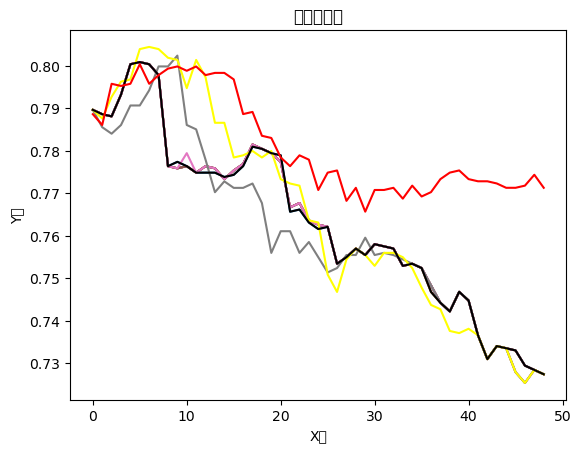

In [23]:
import matplotlib.pyplot as plt

fea_num=[i for i in range(49)]

# 创建图形
plt.plot(fea_num, aver_mean_lis1)
plt.plot(fea_num, aver_mean_lis2)
plt.plot(fea_num, aver_mean_lis3)
plt.plot(fea_num, aver_mean_lis4)
plt.plot(fea_num, aver_mean_lis5)
plt.plot(fea_num, aver_mean_lis6)
plt.plot(fea_num, aver_mean_lis7)
plt.plot(fea_num, aver_mean_lis8)
plt.plot(fea_num, aver_mean_lis9,color="yellow")
plt.plot(fea_num, rfe_SVM_aver_mean_lis,color="black")
plt.plot(fea_num, relief_SVM_aver_mean_lis,color="red")



# 添加标题和标签
plt.title('简单折线图')
plt.xlabel('X轴')
plt.ylabel('Y轴')

# 显示图形
plt.show()


In [50]:
baiyun_accuracy=[]
baiyun_accuracy.append(aver_mean_lis1)
baiyun_accuracy.append(aver_mean_lis2)
baiyun_accuracy.append(aver_mean_lis3)
baiyun_accuracy.append(aver_mean_lis4)
baiyun_accuracy.append(aver_mean_lis5)
baiyun_accuracy.append(aver_mean_lis6)
baiyun_accuracy.append(aver_mean_lis7)
baiyun_accuracy.append(aver_mean_lis8)
baiyun_accuracy.append(aver_mean_lis9)
baiyun_accuracy.append(rfe_SVM_aver_mean_lis)
baiyun_accuracy.append(relief_SVM_aver_mean_lis)

In [51]:
colu=[i for i in range(1,50)]
baiyun_acurracy_dataframe=pd.DataFrame(columns=colu,data=np.array(baiyun_accuracy))
baiyun_acurracy_dataframe.to_csv("baiyun_accuracy.csv")

In [52]:



baiyun_F_measure=[]
baiyun_F_measure.append(F_measure_lis1)
baiyun_F_measure.append(F_measure_lis2)
baiyun_F_measure.append(F_measure_lis3)
baiyun_F_measure.append(F_measure_lis4)
baiyun_F_measure.append(F_measure_lis5)
baiyun_F_measure.append(F_measure_lis6)
baiyun_F_measure.append(F_measure_lis7)
baiyun_F_measure.append(F_measure_lis8)
baiyun_F_measure.append(F_measure_lis9)
baiyun_F_measure.append(rfe_SVM_F_measure_lis)
baiyun_F_measure.append(relief_SVM_F_measure_lis)

In [53]:
colu=[i for i in range(1,50)]
baiyun_F_measure_dataframe=pd.DataFrame(columns=colu,data=np.array(baiyun_F_measure))
baiyun_F_measure_dataframe.to_csv("baiyun_F_measure.csv")